# Character-Level 번역기 만들기(Seq2Seq)

In [3]:
import numpy as np
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

## Preprocessing

### 1. 데이터 불러오기

fra.txt 데이터는 왼쪽의 영어 문장과 오른쪽의 프랑스어 문장 사이에 탭으로 구분되는 구조

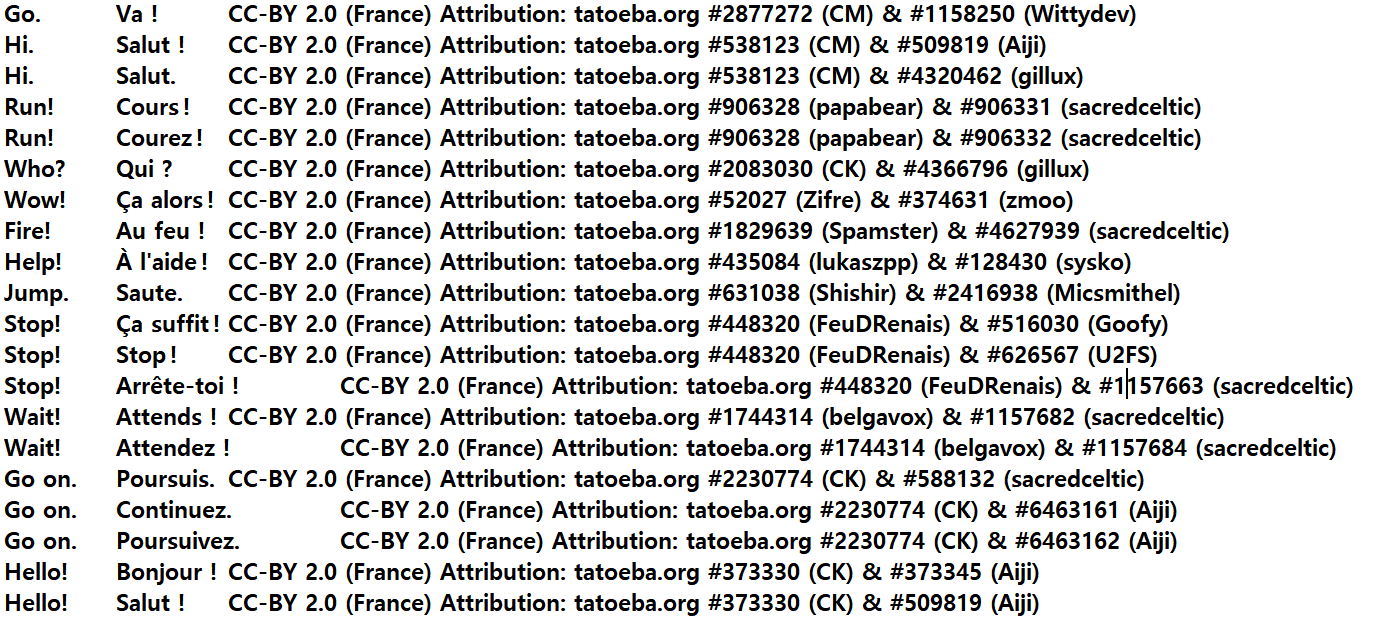

In [4]:
# 데이터 불러오기
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [5]:
# 샘플의 개수 출력
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
len(lines)

178009

In [6]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
49025,I think you're jealous.,Je pense que vous êtes jalouses.
55260,I have to work tomorrow.,"Je dois travailler, demain."
10014,Adjust your tie.,Ajuste ta cravate !
23543,Have you gone nuts?,Es-tu devenue folle ?
13605,Your cat is fat.,Votre chatte est grosse.
568,Forget it.,Laisse tomber.
27421,What's your excuse?,Quelle est ton excuse ?
24614,I really like that.,Ça me plaît beaucoup.
19320,I just got bitten.,Je viens de me faire mordre.
57055,None of these are Tom's.,Il n'y en a aucun à Tom.


### 2. Decoder에 심볼추가

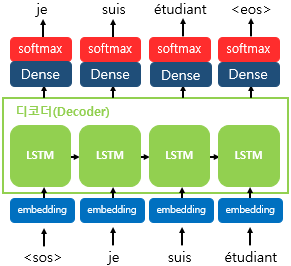
시작을 의미하는 심볼 \<sos>과 종료를 의미하는 심볼 \<eos>을 넣어줌

In [7]:
# <sos>는 \t로 <eos>는 \n로 설정
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
1258,Hurry home.,\t Dépêche-toi d'aller chez toi ! \n
23205,Do you like sports?,\t Aimes-tu le sport ? \n
21509,Today is Saturday.,\t Aujourd'hui c'est samedi. \n
50226,My GPS works very well.,\t Mon GPS fonctionne très bien. \n
33578,You're cantankerous.,\t Tu es acariâtre. \n
9349,Tie your shoes.,\t Noue tes lacets. \n
30119,I stole it from Tom.,\t Je l'ai volé à Tom. \n
56022,I was starting to worry.,\t Je commençais à m'inquiéter. \n
16704,They're students.,\t Elles sont étudiantes. \n
42503,I talked to everybody.,\t J'ai parlé avec tout le monde. \n


### 3. 글자(문자) 집합 구축

In [8]:
# 글자 집합 구축
src_vocab=set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

tar_vocab=set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [9]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)

79
106


영어와 프랑스어에 각각 79, 106개의 글자가 존재

In [10]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


순서를 정해준 뒤 각 글자에 인덱스 부여

In [11]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

### 4. 문장 정수 인코딩

In [12]:
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [31, 58, 10], [31, 58, 10], [41, 70, 63, 2], [41, 70, 63, 2]]


\<sos>는1, \<eos>는 2로 인코딩

In [13]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
      temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2], [1, 3, 29, 67, 73, 70, 71, 105, 4, 3, 2], [1, 3, 29, 67, 73, 70, 57, 78, 105, 4, 3, 2]]


디코더의 예측값과 비교하기 위한 실제값이 필요<br>
실제값은 \<sos>와 \<eos>가 불필요하므로 제거

In [14]:
decoder_target = []
for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(tar_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[3, 48, 53, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2], [3, 29, 67, 73, 70, 71, 105, 4, 3, 2], [3, 29, 67, 73, 70, 57, 78, 105, 4, 3, 2]]


### 5. Padding

패딩 작업으로 영어 데이터는 영어 샘플들끼리, 프랑스어는 프랑스어 샘플들끼리 길이를 맞추어 차원을 통일시킨다

In [15]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

24
76


In [16]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

### 5. one-hot encoding

글자 단위 번역기므로 워드 임베딩은 별도로 사용되지 않으며, 예측값과의 오차 측정에 사용되는 실제값뿐만 아니라 입력값도 원-핫 벡터를 사용

In [17]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### Seq2Seq 기계 번역기 훈련

keras의 functional API 사용

In [18]:
encoder_inputs = Input(shape=(None, src_vocab_size)) #몇개의 글자가 들어올지 모르니 input_length = None
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.

위의 코드에서 encoder_states가 컨텍스트 벡터, decoder로 전해짐

In [19]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) #training 과정이기 때문에 decoder_input에 원래 target을 사용.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [20]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 359s 479ms/step - loss: 0.7795 - val_loss: 0.6790
Epoch 2/50
750/750 [==============================] - 343s 458ms/step - loss: 0.4739 - val_loss: 0.5469
Epoch 3/50
750/750 [==============================] - 339s 452ms/step - loss: 0.3949 - val_loss: 0.4830
Epoch 4/50
750/750 [==============================] - 265s 354ms/step - loss: 0.3506 - val_loss: 0.4432
Epoch 5/50
750/750 [==============================] - 278s 370ms/step - loss: 0.3216 - val_loss: 0.4171
Epoch 6/50
750/750 [==============================] - 274s 366ms/step - loss: 0.2992 - val_loss: 0.3999
Epoch 7/50
750/750 [==============================] - 236s 315ms/step - loss: 0.2826 - val_loss: 0.3872
Epoch 8/50
750/750 [==============================] - 234s 313ms/step - loss: 0.2693 - val_loss: 0.3771
Epoch 9/50
750/750 [==============================] - 242s 322ms/step - loss: 0.2581 - val_loss: 0.3719
Epoch 10/50
750/750 [==============================] - 272s 362m

## Seq2Seq 기계 번역기 동작

전체적인 번역 동작 단계<br>
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻는다.<br>
2. 상태와 \<SOS>에 해당하는 '\t'를 디코더로 보낸다.<br>
3. 디코더가 \<EOS>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복한다.<br>

### 1. encoder 정의

In [21]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

### 2. decoder 설계

In [22]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

단어로부터 인덱스를 얻는 것이 아니라 인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 생성.

In [23]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [24]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [25]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Run!
정답 문장:  Cours ! 
번역기가 번역한 문장:  Cours ça ! 
-----------------------------------
입력 문장: I left.
정답 문장:  Je suis partie. 
번역기가 번역한 문장:  Je suis poiste. 
-----------------------------------
입력 문장: Call us.
정답 문장:  Appelez-nous ! 
번역기가 번역한 문장:  Appelez-nous ! 
-----------------------------------
입력 문장: How nice!
정답 문장:  Comme c'est gentil ! 
번역기가 번역한 문장:  Comme c'est chouette ! 
-----------------------------------
입력 문장: Turn left.
정답 문장:  Tourne à gauche. 
번역기가 번역한 문장:  Tourne la main ! 
